<a href="https://colab.research.google.com/github/deetip/Astro-1221/blob/main/Project_4_calculating_transits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii
import astropy.units as u
import astropy.constants as ac

In [2]:
d = 2 * u.solRad
a = 1 * u.AU
v = np.sqrt (ac.G * u.solMass/ a)
print(v.to(u.m / u.s)) #velocity of earth

29784.691829676933 m / s


In [3]:
t = d/v
print(t.to (u.hour)) # transit for earth

12.976464628547822 h


In [4]:
d = 2 * u.solRad
a = 5 * u.AU
v = np.sqrt (ac.G * u.solMass/ a)
print(v.to(u.m / u.s)) #velocity of jupiter

13320.119124008042 m / s


In [5]:
t = d/v
print(t.to (u.hour)) # transit for jupiter

29.01625701705449 h


In [6]:
delta = (ac.R_jup/ u.solRad) ** 2
print(delta.decompose()) #flux

0.010560169441850944


In [7]:
vel_e = 30 * (u.km / u.s)
vel_s = ac.GM_earth/ac.GM_sun * vel_e
print (vel_s.to(u.m / u.s)) #wobble for earth

0.0901046804655238 m / s


In [8]:
vel_j = 13.32 * (u.km / u.s)
vel_s = ac.GM_jup/ac.GM_sun * vel_j
print (vel_s.to(u.m / u.s)) #wobble for jupiter

12.71519519647141 m / s


In [9]:
from google.colab import files
uploaded = files.upload()

Saving GJ 436b.txt to GJ 436b.txt


In [11]:
dat = astropy.io.ascii.read("GJ 436b.txt")

Text(0, 0.5, 'Normalize Flux')

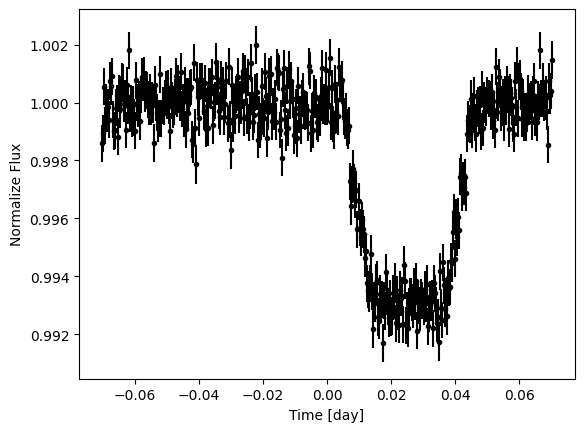

In [13]:
time = dat["col1"] - np.median(dat["col1"])
# rel_mag = dat["col2"]
# flux = 2.514**(1.0 - rel_mag)
flux = dat["col2"]
err = dat["col3"]
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")

In [14]:
def box_model(t, center_time, duration, depth, delta_flux): #function taking (y=x^2). duration is how wide the box is. depth how deep the box it.
  f = np.zeros(np.shape(t)) #out of function has same number as input. f is how flux changes over time
  ind = np.where(np.abs(t - center_time) < (duration / 2.0)) #define range of incedies when wnt to define a value. if nothing happens to star value will be 1. in transit
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0)) #data outside data box. out of transit
  f[ind] = 1.0 + delta_flux
  return(f)

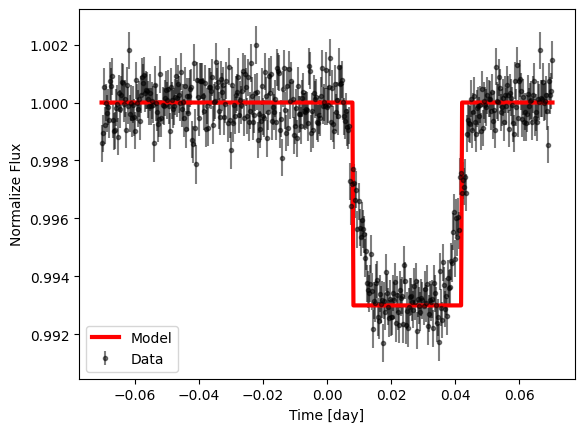

In [58]:
center_time, duration, depth, delta_flux = 0.025, 0.034, 0.007, 0.0 #assigning values to parameters that define model
model = box_model(time, center_time, duration, depth, delta_flux) #parameter value fro model
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data") #how plot data
plt.plot(time, model, color="red", linewidth=3.0, label="Model") #how plot model
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

In [56]:
def calc_reduced_Chi2(O, C, err, n, m):
  Chi2 = np.sum(((O - C)**2) / (err**2))
  reduced_Chi2 = Chi2 / (n-m)
  return(reduced_Chi2)

In [59]:
print(calc_reduced_Chi2(flux, model, err, len(time), 4.0))


2.6830076525121305


In [60]:
def log_likelihood(theta, x, y, yerr):
    center_time, duration, depth, delta_flux = theta
    model = box_model(time, center_time, duration, depth, delta_flux)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [61]:
def log_prior(theta):
    center_time, duration, depth, delta_flux = theta
    if -0.05 < center_time < 0.05 and 0.0 < duration < 1.0 and 0.0 < depth < 1.0 and -0.1 < delta_flux < 0.1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [63]:
def trapezoid_model(t, center_time, duration, depth, delta_flux, ingress): #better model shape to accomadate for shape
  f = np.zeros(np.shape(t))
  ind = np.where(np.abs(t - center_time) < (duration / 2.0))
  f[ind] = 1.0 + delta_flux - depth
  ind = np.where(np.abs(t - center_time) >= (duration / 2.0 + ingress))
  f[ind] = 1.0 + delta_flux
  ind = np.where((np.abs(t - center_time) <= (duration / 2.0 + ingress)) & (np.abs(t - center_time) > (duration / 2.0)))
  for i in ind[0]:
    delta_t = np.abs(np.abs(t[i] - center_time) - (duration / 2.0))
    f[i] = depth / ingress * delta_t + 1.0 + delta_flux - depth
  return(f)

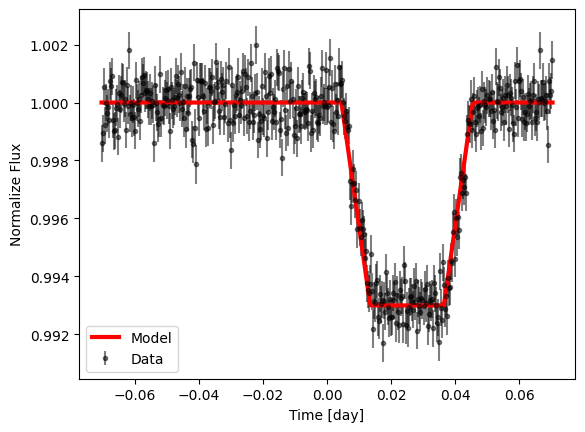

In [88]:
center_time, duration, depth, delta_flux, ingress = 0.025, 0.023, 0.007, 0.0, 0.009
model = trapezoid_model(time, center_time, duration, depth, delta_flux, ingress)
plt.errorbar(time, flux, yerr=err, marker=".", color="black", linestyle="none", alpha=0.5, label="Data")
plt.plot(time, model, color="red", linewidth=3.0, label="Model")
plt.xlabel("Time [day]")
plt.ylabel("Normalize Flux")
plt.legend();

In [82]:
def calc_reduced_Chi2(O, C, err, n, m):
  Chi2 = np.sum(((O - C)**2) / (err**2))
  reduced_Chi2 = Chi2 / (n-m)
  return(reduced_Chi2)

In [89]:
print(calc_reduced_Chi2(flux, model, err, len(time), 4.0))

1.1115415470155916
